## 1. Candy Crush Saga : Loading Libraries 


In [ ]:
# This sets the size of plots to a good default.
options(repr.plot.width = 5, repr.plot.height = 4)

# Loading in packages
library(dplyr)
library(ggplot2)
library(readr)

## 2. The data set
<p>The dataset we will use contains one week of data from a sample of players who played Candy Crush back in 2014. The data is also from a single <em>episode</em>, that is, a set of 15 levels. It has the following columns:</p>
<ul>
<li><strong>player_id</strong>: a unique player id</li>
<li><strong>dt</strong>: the date</li>
<li><strong>level</strong>: the level number within the episode, from 1 to 15.</li>
<li><strong>num_attempts</strong>: number of level attempts for the player on that level and date.</li>
<li><strong>num_success</strong>: number of level attempts that resulted in a success/win for the player on that level and date.</li>
</ul>


In [ ]:
# Reading in the data
data <- read_csv("datasets/candy_crush.csv")

# Printing out the first six rows
head(data)

Rows: 16865 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): player_id
dbl  (3): level, num_attempts, num_success
date (1): dt

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


player_id,dt,level,num_attempts,num_success
<chr>,<date>,<dbl>,<dbl>,<dbl>
6dd5af4c7228fa353d505767143f5815,2014-01-04,4,3,1
c7ec97c39349ab7e4d39b4f74062ec13,2014-01-01,8,4,1
c7ec97c39349ab7e4d39b4f74062ec13,2014-01-05,12,6,0
a32c5e9700ed356dc8dd5bb3230c5227,2014-01-03,11,1,1
a32c5e9700ed356dc8dd5bb3230c5227,2014-01-07,15,6,0
b94d403ac4edf639442f93eeffdc7d92,2014-01-01,8,8,1


## 3. Checking the data set
Counting how many players we have in the sample and how old is our data.</p>

In [ ]:
# Count and display the number of unique players
print("Number of players:")
length(unique(data$player_id))

# Display the date range of the data
print("Period for which we have data:")
range(data$dt)

[1] "Number of players:"


[1] 6814

[1] "Period for which we have data:"


[1] "2014-01-01" "2014-01-07"

## 4. Computing level difficulty
<p>Within each Candy Crush episode, there is a mix of easier and tougher levels. Luck and individual skill make the number of attempts required to pass a level different from player to player. The assumption is that difficult levels require more attempts on average than easier ones. That is, <em>the harder</em> a level is, <em>the lower</em> the probability to pass that level in a single attempt is.</p>
<p>A simple approach to model this probability is as a <a href="https://en.wikipedia.org/wiki/Bernoulli_process">Bernoulli process</a>; as a binary outcome (you either win or lose) characterized by a single parameter <em>p<sub>win</sub></em>: the probability of winning the level in a single attempt. This probability can be estimated for each level as:</p>
<p><img src="https://assets.datacamp.com/production/project_139/img/latex1.png" style="width:150px"></p>
<!-- $$p_{win} = \frac{\sum wins}{\sum attempts}$$ -->
<p>For example, let's say a level has been played 10 times and 2 of those attempts ended up in a victory. Then the probability of winning in a single attempt would be <em>p<sub>win</sub></em> = 2 / 10 = 20%.</p>
<p>Now, let's compute the difficulty <em>p<sub>win</sub></em> separately for each of the 15 levels.</p>

In [ ]:
# Calculating level difficulty
difficulty <- data %>%
  group_by(level) %>%
  summarise(attempts = sum(num_attempts), wins = sum(num_success)) %>%
  mutate(p_win = wins / attempts)

# Printing out the calculated difficulty
difficulty

level,attempts,wins,p_win
<dbl>,<dbl>,<dbl>,<dbl>
1,1322,818,0.61875946
2,1285,666,0.51828794
3,1546,662,0.42820181
4,1893,705,0.37242472
5,6937,634,0.09139397
6,1591,668,0.41986172
7,4526,614,0.13566063
8,15816,641,0.04052858
9,8241,670,0.08130081


## 5. Plotting difficulty profile
Plotting a line graph with the levels on the X-axis and the difficulty (<em>p<sub>win</sub></em>) on the Y-axis.

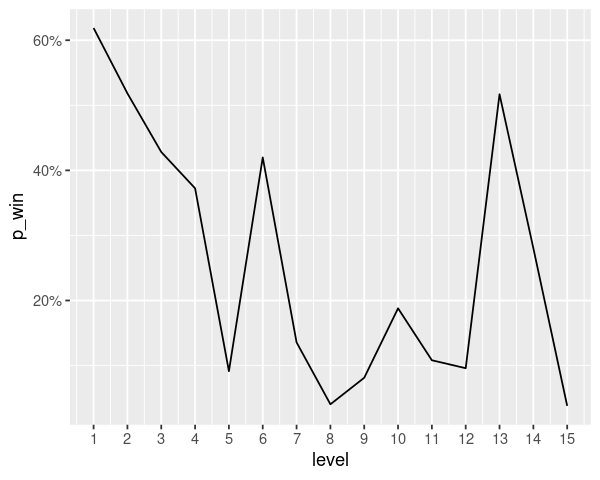

In [ ]:
# Plotting the level difficulty profile
difficulty %>%
  ggplot(aes(x = level, y = p_win)) + 
    geom_line() + 
    scale_x_continuous(breaks = 1:15) +
    scale_y_continuous(label = scales::percent)

## 6. Spotting hard levels
<p>Defining a threshold of difficulty, say 10%, and label levels with <em>p<sub>win</sub></em> &lt; 10% as <em>hard</em>. It's relatively easy to spot these hard levels on the plot, but we can make the plot more friendly by explicitly highlighting the hard levels.</p>

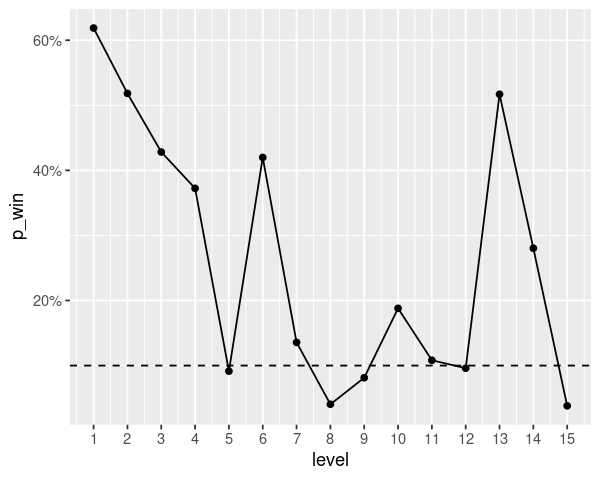

In [ ]:
# Adding points and a dashed line
difficulty %>%
  ggplot(aes(x = level, y = p_win)) + 
    geom_line() + geom_point() +
    scale_x_continuous(breaks = 1:15) +
    scale_y_continuous(label = scales::percent) +
    geom_hline(yintercept = 0.1, linetype = 'dashed')

## 7. Computing uncertainty
 </p>
Using the <a href="https://en.wikipedia.org/wiki/Standard_error"><em>Standard error</em></a> as a measure of uncertainty:</p>
<p><img src="https://assets.datacamp.com/production/project_139/img/latex2.png" style="width:115px"></p>

<p>Here <em>n</em> is the number of datapoints and <em>σ<sub>sample</sub></em> is the sample standard deviation. For a Bernoulli process, the sample standard deviation is: </p>
<p><img src="https://assets.datacamp.com/production/project_139/img/latex3.png" style="width:195px"></p>
<!-- $$


<p>Calculate the standard error for each level.</p>

In [ ]:
# Computing the standard error of p_win for each level
difficulty <- difficulty %>%
  mutate(error = sqrt(p_win * (1 - p_win) / attempts))

## 8. Showing uncertainty
<p>Now that we have a measure of uncertainty for each levels' difficulty estimate let's use <em>error bars</em> to show this uncertainty in the plot. We will set the length of the error bars to one standard error. The upper limit and the lower limit of each error bar should then be <em>p<sub>win</sub></em> + <em>σ<sub>error</sub></em> and <em>p<sub>win</sub></em> - <em>σ<sub>error</sub></em>, respectively.</p>

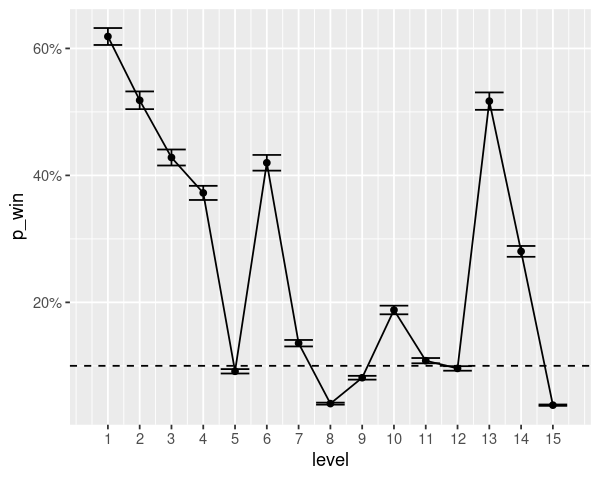

In [ ]:
# Adding standard error bars
difficulty %>%
  ggplot(aes(x = level, y = p_win)) + 
    geom_line() + geom_point() +
    scale_x_continuous(breaks = 1:15) +
    scale_y_continuous(label = scales::percent) +
    geom_hline(yintercept = 0.1, linetype = 'dashed') +
    geom_errorbar(aes(ymin = p_win - error, ymax = p_win + error))

## 9. A final metric
<p>It looks like our difficulty estimates are pretty precise! Using this plot, a level designer can quickly spot where the hard levels are and also see if there seems to be too many hard levels in the episode.</p>
<p>One question a level designer might ask is: "How likely is it that a player will complete the episode without losing a single time?" Let's calculate this using the estimated level difficulties!</p>

In [ ]:
# The probability of completing the episode without losing a single time
p <- prod(difficulty$p_win)

# Printing it out
p

[1] 9.447141e-12

## 10. Should our level designer worry?
<p>Given the probability we just calculated, should our level designer worry about that a lot of players might complete the episode in one attempt?</p>

In [ ]:
# Should our level designer worry about that a lot of 
# players will complete the episode in one attempt?
should_the_designer_worry =  FALSE